In [1]:
import evo_prot_grad
from transformers import AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set_style("whitegrid")
# set font size seaborn
sns.set_context("notebook", font_scale=1.25)

%load_ext autoreload
%autoreload 2

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HuggingFace ESM2 8M model + Supervised fluorescence regression model

In [2]:
# HuggingFace ESM2 8M model
esm2_expert = evo_prot_grad.get_expert('esm', temperature = 1.0, device = 'cuda')

# Supervised fluorescence regression model
gfp_expert = evo_prot_grad.get_expert(
                        'onehot_downstream_regression',
                        temperature = 1.0,
                        model = AutoModel.from_pretrained('NREL/avGFP-fluorescence-onehot-cnn',trust_remote_code=True),
                        device = 'cuda')

variants, scores = evo_prot_grad.DirectedEvolution(
                        wt_fasta = 'test/gfp.fasta',
                        output = 'all',
                        experts = [esm2_expert, gfp_expert],
                        parallel_chains = 16,
                        n_steps = 1000,              
                        max_mutations = 15,
                        verbose = False
)()


Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


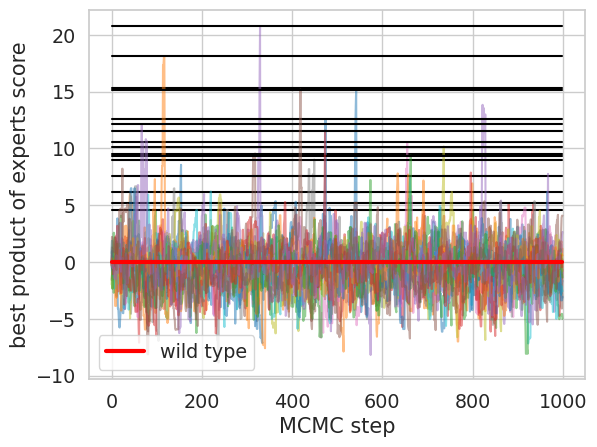

In [3]:
plt.figure()
for i in range(scores.shape[1]):
    plt.plot(scores[:,i], alpha=0.5)
    best_step = np.argmax(scores[:,i])
    best_score = scores[best_step,i]
    plt.plot(np.arange(0,scores.shape[0]), best_score * np.ones((scores.shape[0],)), c='black')
plt.plot(np.arange(0,scores.shape[0]), np.zeros((scores.shape[0],)), c='red', linewidth=3, label='wild type')
plt.xlabel('MCMC step')
plt.ylabel('best product of experts score')
plt.legend()
plt.show()

In [4]:
with open('test/gfp.fasta', 'r') as f:
    for line in f:
        if line[0] != '>':
            wtseq = ' '.join(line.strip())

for i in range(scores.shape[1]):
    best_step = np.argmax(scores[:,i])
    print(f'chain {i}, score: {scores[best_step,i]}')
    evo_prot_grad.common.utils.print_variant_in_color(variants[best_step][i], wtseq)

chain 0, score: 15.289830207824707
S K G E S L F T G V V P I L V E L D G D V N G H K F S V S G E G E G E A T Y G K L T L K F I C T T G K L P V P W P T L V T T L S Y G V Q C F S R Y P D H M K Q H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I G D G P V L L P D N H Y L S T Q S A L S K D P N E K R D H M V L L E F V T A A G I T H G M D E L Y K
chain 1, score: 6.111212253570557
S K G E T L F T G K V P I L V E L D G S V N G H K F S V S G E G E C D A T Y G K L T L K F D C T T G K L P V P W P T L V T T L S Y G V Q C F S R Y P D H M K Q H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G E K L E Y N Y N S H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I Y D I P V L L P D N T Y L S T Q G A L S K D P N E K R D H M V L L E F V T A A G I T

## Preserve regions in the wild type sequence

In [5]:
variants, scores = evo_prot_grad.DirectedEvolution(
                        wt_fasta = 'test/gfp.fasta',
                        output = 'all',
                        experts = [esm2_expert, gfp_expert],
                        parallel_chains = 16,
                        n_steps = 1000,              
                        max_mutations = 15,
                        verbose = False,
                        preserved_regions = [(0,13),(150,237)]
)()


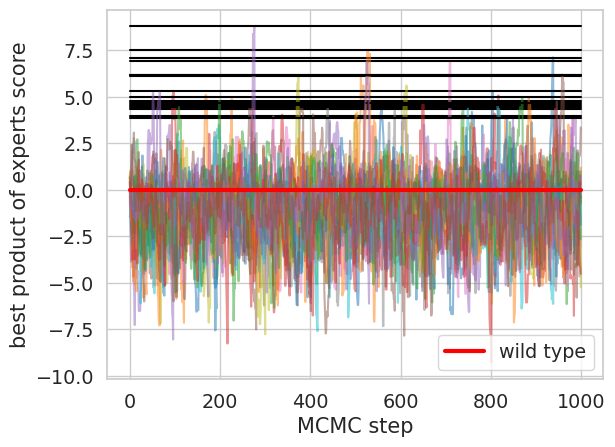

chain 0, score: 7.121396064758301
S K G E E L F T G V V P I L V E L D G D V K G H K F S V S G E G E Q D P T Y G K L T L K F I C T T K K L P P P P P T L V T T L S Y D V Q C F S R Y P D H Y K Q H D F F K S A M P E G Y K Q E R T I F F K D D G N Y K T R A E L K F E G D T L V N F I E L I G I D F K E D G N I L G H K G E Y N G N H H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I G D G P V L L P D N H Y L S T Q S A L S K D P N E K R D H M V L L E F V T A A G I T H G M D E L Y K
chain 1, score: 6.198309898376465
S K G E E L F T G V V P I L V E L D G D V N G T K F S V S G E G E G D A T Y G K L T L K F K T T T G K L P V P L P T L V T T E S Y G V Q D F S R Y P D H M K Q H D F F K S A M N E G Y V Q L R D I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I G D G P V L L P D N H Y L S T Q S A L S K D P N E K R D H M V L L E F V T A A G I T 

In [6]:
plt.figure()
for i in range(scores.shape[1]):
    plt.plot(scores[:,i], alpha=0.5)
    best_step = np.argmax(scores[:,i])
    best_score = scores[best_step,i]
    plt.plot(np.arange(0,scores.shape[0]), best_score * np.ones((scores.shape[0],)), c='black')
plt.plot(np.arange(0,scores.shape[0]), np.zeros((scores.shape[0],)), c='red', linewidth=3, label='wild type')
plt.xlabel('MCMC step')
plt.ylabel('best product of experts score')
plt.legend()
plt.show()

for i in range(scores.shape[1]):
    best_step = np.argmax(scores[:,i])
    print(f'chain {i}, score: {scores[best_step,i]}')
    evo_prot_grad.common.utils.print_variant_in_color(variants[best_step][i], wtseq)